In [33]:
from symenergy import logger
logger.setLevel('ERROR')
import symenergy.core.model as model

In [34]:
m = model.Model(curtailment=True, slot_weight=12)

m.add_slot(name='day', load=5000, vre=8500)
m.add_slot(name='night', load=4500, vre=850)
m.add_plant(name='n', vc0=10, capacity=3500, fcom=9, cap_ret=True)
m.add_plant(name='g', vc0=90)
m.add_storage(name='phs', eff=0.75, capacity=1, energy_capacity=1, slots_map={'chg': ['day'] , 'dch': ['night']})

#m.cache.delete()
m.generate_solve()

In [35]:
m.print_results(218)

******************** curt_p_day ********************
0
******************** curt_p_night ********************
0
******************** g_p_day ********************
0
******************** g_p_night ********************
eff_phs_none**1.0*(l_day - vre_day*vre_scale_none) + l_night - vre_night*vre_scale_none
******************** lb_curt_pos_p_day ********************
eff_phs_none**0.5*w_none*(ec_phs_none - eff_phs_none**0.5*vc0_g_none)
******************** lb_curt_pos_p_night ********************
-vc0_g_none*w_none
******************** lb_g_pos_p_day ********************
w_none*(-ec_phs_none*eff_phs_none**0.5 + eff_phs_none**1.0*vc0_g_none - vc0_g_none)
******************** lb_n_pos_C_ret_none ********************
fcom_n_none
******************** lb_n_pos_p_day ********************
w_none*(-ec_phs_none*eff_phs_none**0.5 + eff_phs_none**1.0*vc0_g_none - vc0_n_none)
******************** lb_n_pos_p_night ********************
w_none*(vc0_g_none - vc0_n_none)
******************** n_C_ret_none ***

In [36]:
display(m.df_comb.set_index('idx').loc[218, m.constrs_cols_neq].T)

act_lb_n_pos_p_day              True
act_lb_n_pos_p_night            True
act_lb_n_pos_C_ret_none         True
act_lb_n_p_cap_C_day           False
act_lb_n_p_cap_C_night         False
act_lb_n_C_ret_cap_C_none      False
act_lb_g_pos_p_day              True
act_lb_g_pos_p_night           False
act_lb_phs_pos_pchg_day        False
act_lb_phs_pos_e_none          False
act_lb_phs_pos_pdch_night      False
act_lb_phs_pchg_cap_C_day      False
act_lb_phs_pdch_cap_C_night    False
act_lb_phs_e_cap_E_none        False
act_lb_curt_pos_p_day           True
act_lb_curt_pos_p_night         True
Name: 218, dtype: object

In [37]:
m.parameters(('name', 'value'))

[('vc0_n_none', 10),
 ('fcom_n_none', 9),
 ('C_n_none', 3500),
 ('vc0_g_none', 90),
 ('l_day', 5000),
 ('vre_day', 8500),
 ('w_none', 12),
 ('l_night', 4500),
 ('vre_night', 850),
 ('ec_phs_none', 1e-12),
 ('eff_phs_none', 0.75),
 ('C_phs_none', 1),
 ('E_phs_none', 1),
 ('vre_scale_none', 1)]

In [38]:
m.comps['phs'].constraints(('name', 'mlt', 'expr_0'), is_equality_constraint=False)

[('phs_pos_pchg_day', lb_phs_pos_pchg_day, phs_pchg_day),
 ('phs_pos_e_none', lb_phs_pos_e_none, phs_e_none),
 ('phs_pos_pdch_night', lb_phs_pos_pdch_night, phs_pdch_night),
 ('phs_pchg_cap_C_day', lb_phs_pchg_cap_C_day, -C_phs_none + phs_pchg_day),
 ('phs_pdch_cap_C_night',
  lb_phs_pdch_cap_C_night,
  -C_phs_none + phs_pdch_night),
 ('phs_e_cap_E_none', lb_phs_e_cap_E_none, -E_phs_none + phs_e_none)]

In [39]:
vre_day = 1      # relative VRE production night
vre_night = 0.1  # relative VRE production night
tot_l = m.slots['day'].l.value + m.slots['night'].l.value  # total load

m.slots['day'].vre.value = vre_day / (vre_day + vre_night) * tot_l
m.slots['night'].vre.value = vre_night / (vre_day + vre_night) * tot_l

In [40]:
import symenergy.evaluator.evaluator as evaluator
import numpy as np

phs_C_max = m.slots['day'].l.value * 0.5  # <-- 50% of maximum load

x_vals = {m.vre_scale: np.linspace(0, 1, 21),
          m.comps['phs'].C: [0, phs_C_max],
          m.comps['phs'].E: [None], # <-- set later
          m.comps['phs'].eff: [0.75, 0.9],
          m.comps['n'].C: [2000, 4000, 5000]}

ev = evaluator.Evaluator(m, x_vals=x_vals, drop_non_optimum=False)
ev.cache_lambd.delete()
ev.get_evaluated_lambdas_parallel()

In [41]:
import inspect
print(inspect.getsource(
ev.df_lam_func.set_index(['idx', 'func']).loc[(3330, 'phs_pchg_day'), 'lambd_func']))

def _98610945ede4c0de22cac7687d8a3aa3(vre_scale_none,C_phs_none,E_phs_none,eff_phs_none,C_n_none):
    return((1/12)*E_phs_none*eff_phs_none**(-0.5))



In [42]:
ev.df_x_vals.head()

,vre_scale_none,C_phs_none,E_phs_none,eff_phs_none,C_n_none
0,0.0,0.0,None,0.75,2000
1,0.0,0.0,None,0.75,4000
2,0.0,0.0,None,0.75,5000
3,0.0,0.0,None,0.90,2000
4,0.0,0.0,None,0.90,4000


In [43]:
dd_90 = 4
dd_75 = 14 

ev.df_x_vals['E_phs_none'] = ev.df_x_vals.C_phs_none
ev.df_x_vals.loc[ev.df_x_vals.eff_phs_none == 0.90, 'E_phs_none'] *= dd_90
ev.df_x_vals.loc[ev.df_x_vals.eff_phs_none == 0.75, 'E_phs_none'] *= dd_75

mask_vre = (ev.df_x_vals.vre_scale_none.isin(np.linspace(0, 1, 11))
            | ev.df_x_vals.vre_scale_none.isin(np.linspace(0.55, 0.75, 21)))
mask_phs = (ev.df_x_vals.C_phs_none.isin(np.linspace(0, phs_C_max, 6)))

ev.df_x_vals = ev.df_x_vals.loc[mask_vre | mask_phs]

print(ev.df_x_vals.head(10))
print('Length: ', len(ev.df_x_vals))

   vre_scale_none  C_phs_none  E_phs_none  eff_phs_none  C_n_none
0             0.0         0.0         0.0          0.75      2000
1             0.0         0.0         0.0          0.75      4000
2             0.0         0.0         0.0          0.75      5000
3             0.0         0.0         0.0          0.90      2000
4             0.0         0.0         0.0          0.90      4000
5             0.0         0.0         0.0          0.90      5000
6             0.0      2500.0     35000.0          0.75      2000
7             0.0      2500.0     35000.0          0.75      4000
8             0.0      2500.0     35000.0          0.75      5000
9             0.0      2500.0     10000.0          0.90      2000
Length:  252


In [44]:
ev.cache_eval.delete()
ev.expand_to_x_vals_parallel()

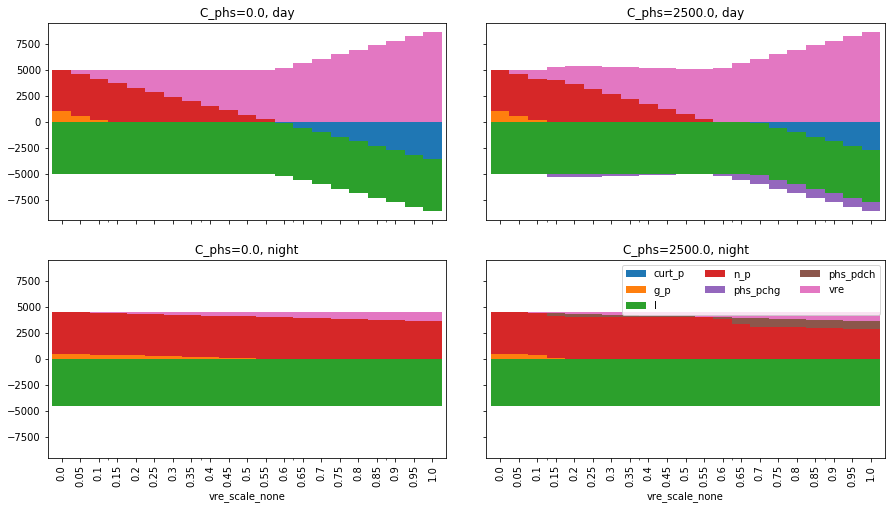

In [45]:
import matplotlib.pyplot as plt
df = ev.df_bal
df = df.loc[-df.func_no_slot.str.contains('tc', 'lam')
           & df.eff_phs_none.isin([0.9])
           & df.C_n_none.isin([4000])
           & -df.slot.isin(['global'])
           ]

df['lambd'] = df.lambd.astype(float)
df['vre_scale_none'] = df.vre_scale_none.apply(lambda x: round(x*10000)/10000)

dfpv = df.pivot_table(columns='func_no_slot', values='lambd', index=['C_phs_none', 'slot', 'vre_scale_none'])

list_slot = dfpv.index.get_level_values('slot').unique()
list_c_phs = dfpv.index.get_level_values('C_phs_none').unique()

fig, axarr = plt.subplots(len(list_slot), len(list_c_phs), sharex=True, sharey=True,
                          gridspec_kw={'wspace': 0.1,}, figsize=(15,8))
list_slot
for nslot, slot in enumerate(list_slot):
    for nc_phs, c_phs in enumerate(list_c_phs):

        ax = axarr[nslot][nc_phs]
        dfpv.loc[(c_phs, slot)].plot.bar(ax=ax, legend=False, use_index=True, stacked=True, width=1)
        
        ax.set_title('C_phs=%s, %s'%(c_phs, slot))

        
leg = ax.legend(ncol=3)

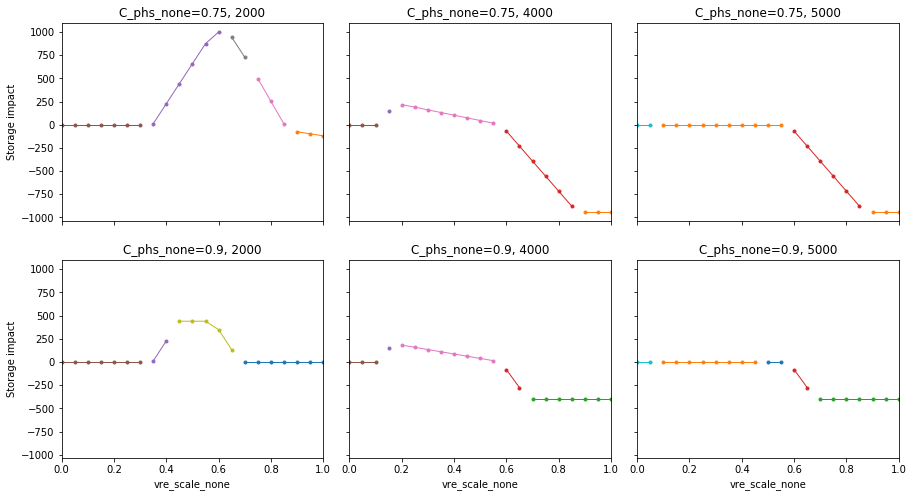

In [46]:
df = ev.df_exp
df = df.loc[df.func.str.contains('n_p_')
           & df.is_optimum.isin([True])
           & -df.slot.isin(['global'])]

dfdiff = df.pivot_table(index=[x for x in ev.x_name if not x in ['E_phs_none', 'C_phs_none']] + ['func'],
                        values='lambd', columns='C_phs_none')
dfdiff['diff'] = dfdiff[2500] - dfdiff[0]

dfcc = df.loc[df.C_phs_none == 2500].set_index(dfdiff.index.names)['idx']
dfdiff = dfdiff.reset_index().join(dfcc, on=dfdiff.index.names)

dfpv = dfdiff.pivot_table(index=['eff_phs_none', 'C_n_none', 'vre_scale_none'], 
                          columns='idx', values='diff')

list_eff = dfpv.index.get_level_values('eff_phs_none').unique()
list_c_n = dfpv.index.get_level_values('C_n_none').unique()

fig, axarr = plt.subplots(len(list_eff), len(list_c_n), sharex=True, sharey=True,
                          gridspec_kw={'wspace': 0.1,}, figsize=(15,8))

for neff, eff in enumerate(list_eff):
    for nc_n, c_n in enumerate(list_c_n):

        ax = axarr[neff][nc_n] if isinstance(axarr, np.ndarray) else axarr
        dfpv.loc[(eff, c_n)].plot(ax=ax, legend=False, marker='.',use_index=True, stacked=False, linewidth=1)
        
        ax.set_title('C_phs_none=%s, %s'%(eff, c_n))
        ax.set_ylabel('Storage impact')